In [10]:
import yfinance as yf
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

In [14]:
df = pd.read_csv('D:\\python-project\\BTC_Price_Prediction\\BTC_2013_2023.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df['Price'] = df.Price.str.replace(',','')
df.set_index('Date',inplace=True)
y = df['Price']
y = y.values.reshape(-1, 1)

In [15]:
#scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(y)
y = scaler.transform(y)

In [16]:
# create input and output sequences
n_lookback = 60 # last 60 days
n_forecast = 30 # forecast 30 next days based on 60 nearest days

In [21]:
X = []
Y = []
for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])
X = np.array(X)
Y = np.array(Y)

In [27]:
# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=0)

#generate the forecast
X_ = y[- n_lookback:] # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)
Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 [==============================] - 1s 1s/step


In [38]:
df_past = df[['Price']].reset_index()
df_past.rename(columns={'index': 'Date','Price': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

In [39]:
df_past

,Date,Actual,Forecast
0,2013-01-01,13.3,NaN
1,2013-01-02,13.3,NaN
2,2013-01-03,13.4,NaN
3,2013-01-04,13.5,NaN
4,2013-01-05,13.4,NaN
...,...,...,...
3729,2023-03-19,27958.70,NaN
3730,2023-03-20,27720.50,NaN
3731,2023-03-21,28114.00,NaN
3732,2023-03-22,27261.70,NaN


In [45]:
df_future = pd.DataFrame(columns=['Date','Actual','Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

In [46]:
df_future

,Date,Actual,Forecast
0,2023-03-24,NaN,26986.666016
1,2023-03-25,NaN,28066.560547
2,2023-03-26,NaN,27341.212891
3,2023-03-27,NaN,27587.500000
4,2023-03-28,NaN,26691.847656
5,2023-03-29,NaN,26993.000000
6,2023-03-30,NaN,27487.154297
7,2023-03-31,NaN,26824.460938
8,2023-04-01,NaN,26537.652344
9,2023-04-02,NaN,26793.814453


In [47]:
past = df_past[['Date','Actual']]
past.rename(columns={'Actual':'Price'},inplace=True)

predict = df_future[['Date','Forecast']]
predict.rename(columns={'Forecast':'Price'},inplace=True)

result = past.append(predict).set_index('Date')
result = result.reset_index()

C:\Users\84335\AppData\Local\Temp\ipykernel_17644\230685235.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = past.append(predict).set_index('Date')


In [48]:
result

,Date,Price
0,2013-01-01,13.3
1,2013-01-02,13.3
2,2013-01-03,13.4
3,2013-01-04,13.5
4,2013-01-05,13.4
...,...,...
3759,2023-04-18,25620.949219
3760,2023-04-19,25554.707031
3761,2023-04-20,26907.310547
3762,2023-04-21,25685.998047


In [49]:
result.dtypes

Date     datetime64[ns]
Price            object
dtype: object

<AxesSubplot: xlabel='Date'>

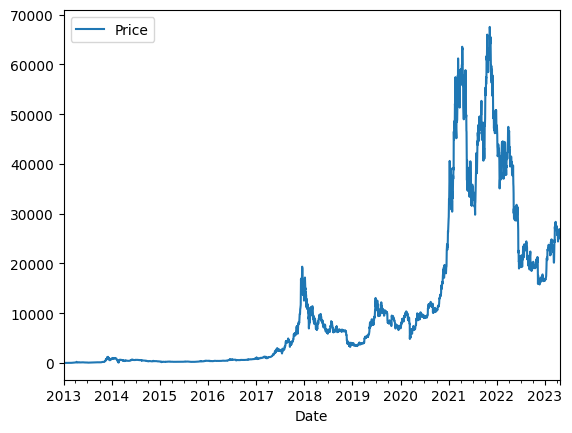

In [51]:
result['Price'] = result['Price'].astype('float')
result.plot(x='Date', y='Price')

<AxesSubplot: xlabel='Date'>

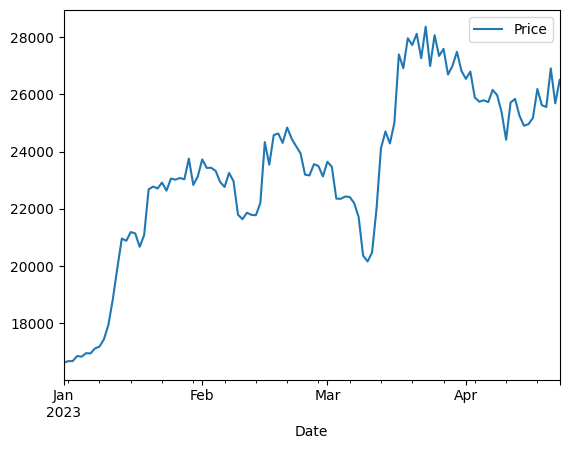

In [52]:
result[result['Date'] >= '2023-01-01'].plot(x='Date',y='Price')

In [53]:
result[result['Date'] >= '2023-03-31']

,Date,Price
3741,2023-03-31,26824.460938
3742,2023-04-01,26537.652344
3743,2023-04-02,26793.814453
3744,2023-04-03,25883.687500
3745,2023-04-04,25742.900391
3746,2023-04-05,25792.451172
3747,2023-04-06,25726.255859
3748,2023-04-07,26153.474609
3749,2023-04-08,25968.501953
3750,2023-04-09,25370.851562
